In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
import shap
from mplsoccer import Pitch, VerticalPitch, Standardizer, add_image
from scipy.ndimage import gaussian_filter
from sklearn.inspection import permutation_importance
from sklearn.decomposition import NMF
from PIL import Image
from urllib.request import urlopen
from matplotlib import rcParams
from matplotlib.cm import get_cmap
from PIL import Image
from urllib.request import urlopen
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mtick
from pdpbox import pdp

C:\Users\ay54372\Miniconda3\envs\expected-goals\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load model and data

In [2]:
df_lgbm = pd.read_parquet(os.path.join('..', 'data', 'modelling', 'lgbm.parquet'))
df_X = df_lgbm.drop(['goal', 'split', 'match_id', 'wyscout_id', 'statsbomb_id'], axis=1).copy()
df_xg = pd.read_parquet(os.path.join('..', 'data', 'modelling', 'xg_shap.parquet'))

In [3]:
df_all = pd.read_parquet(os.path.join('..', 'data', 'shots.parquet'))

In [4]:
model = load(os.path.join('..', 'models', 'lgbm_model.joblib'))

In [5]:
STATSBOMB = os.path.join('..', 'data', 'statsbomb')
df_statsbomb_event = pd.read_parquet(os.path.join(STATSBOMB, 'event.parquet'))
df_statsbomb_freeze = pd.read_parquet(os.path.join(STATSBOMB, 'freeze.parquet'))
df_statsbomb_lineup = pd.read_parquet(os.path.join(STATSBOMB, 'lineup.parquet'))
df_statsbomb_match = pd.read_parquet(os.path.join(STATSBOMB, 'match.parquet'))

Load StatsBomb logos

In [6]:
logo = np.array(Image.open('SB_Regular.png'))

Add Jersey number to freeze frame

In [7]:
df_statsbomb_freeze = df_statsbomb_freeze.merge(df_statsbomb_lineup[['match_id', 'player_id', 'jersey_number']],
                                                how='left', on=['match_id', 'player_id'], validate='m:1')

Add on Xg to original shots dataframe

In [8]:
df_all = df_all.merge(df_xg.loc[df_xg.statsbomb_id.notnull(), ['match_id', 'statsbomb_id', 'xg']], how='left')
df_all = df_all.merge(df_xg.loc[df_xg.wyscout_id.notnull(), ['match_id', 'wyscout_id', 'xg']], how='left', 
                      on=['match_id', 'wyscout_id'], suffixes=['', '_1'])
df_all.loc[df_all.xg.isnull(), 'xg'] = df_all.loc[df_all.xg.isnull(), 'xg_1']
df_all.drop(['xg_1'], axis=1, inplace=True)

Add on StatsBomb xG

In [9]:
df_statsbomb_shots = df_statsbomb_event.loc[df_statsbomb_event.type_name == 'Shot', ['id', 'shot_statsbomb_xg']].copy()
df_statsbomb_shots.rename({'id': 'statsbomb_id'}, axis=1, inplace=True)
df_all = df_all.merge(df_statsbomb_shots, left_on='statsbomb_id', right_on='statsbomb_id', how='left')

Compare StatsBomb xG and model

In [10]:
df_all['xg_difference'] = df_all.shot_statsbomb_xg - df_all.xg

In [11]:
df_xg_diff = df_all.loc[df_all['xg_difference'].notnull(), ['x', 'y', 'xg_difference']]

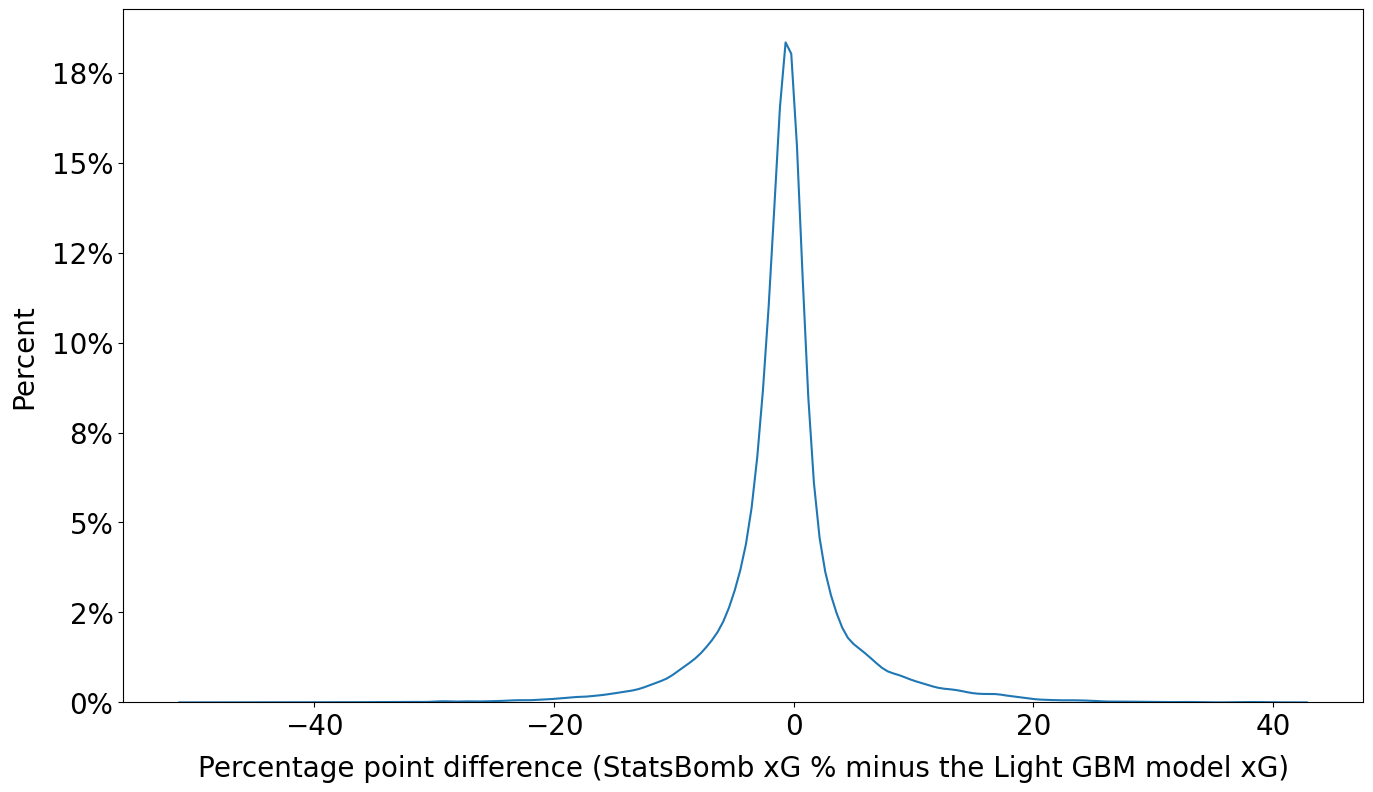

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.kdeplot(df_all['xg_difference'].values * 100, ax=ax)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel('Percent', fontsize=20, labelpad=10)
ax.set_xlabel('Percentage point difference (StatsBomb xG % minus the Light GBM model xG)', fontsize=20, labelpad=10)
fig.savefig(os.path.join('..', 'figures', '23_model_comparison_with_statsbomb_xg_dist'),
            bbox_inches = 'tight', pad_inches = 0)

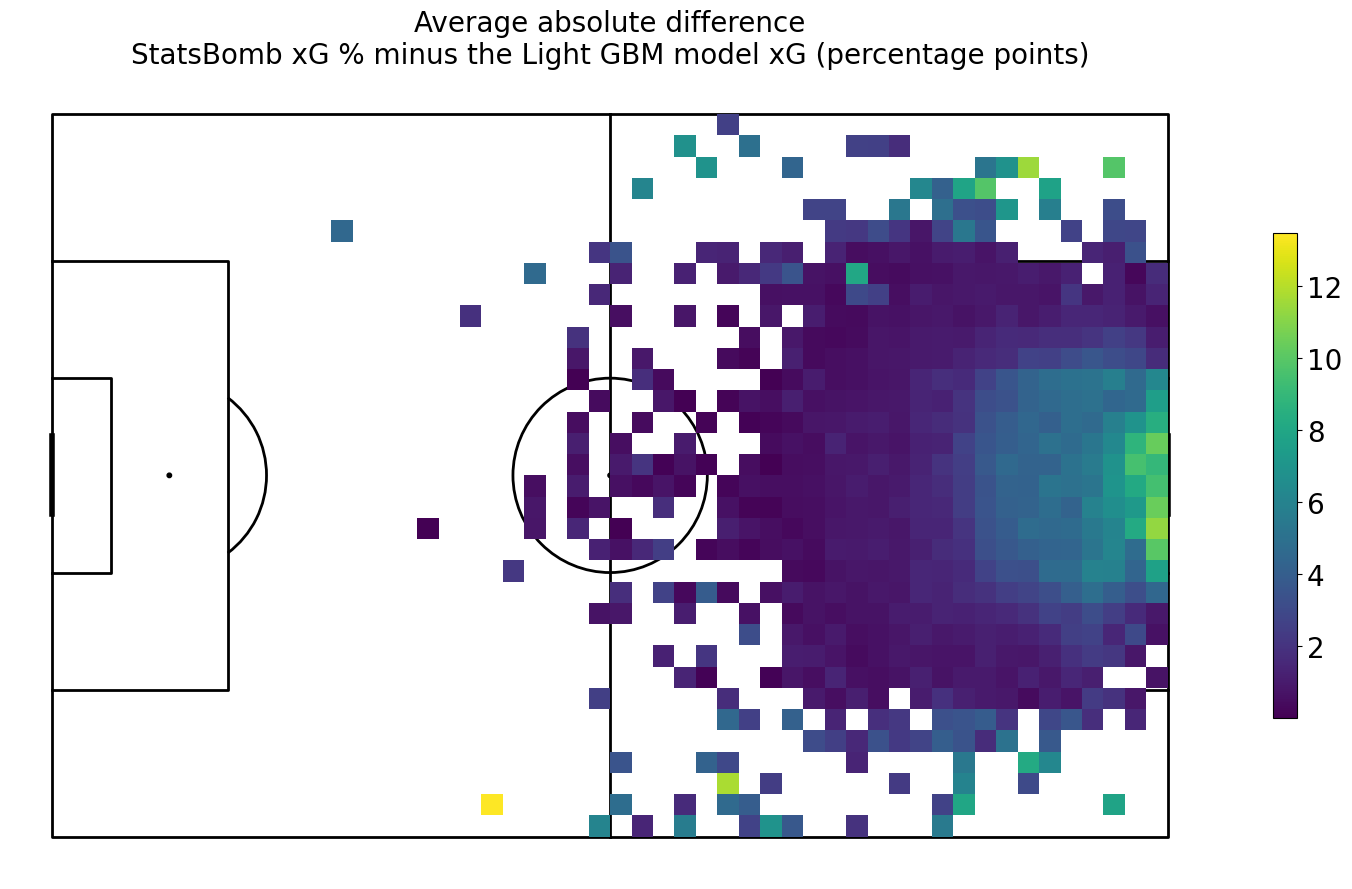

In [13]:
pitch = Pitch(pitch_type='uefa', line_color='black')
fig, ax = pitch.draw(figsize=(16, 9))
bs = pitch.bin_statistic(df_xg_diff.x, df_xg_diff.y, values=np.abs(df_xg_diff.xg_difference), statistic='mean', bins=(52, 34))
bs['statistic'] = bs['statistic'] * 100.
pcm = pitch.heatmap(bs, ax=ax, cmap='viridis', edgecolors='None')
cbar = fig.colorbar(pcm, fraction=0.045, pad=0.04, shrink=0.6)
cbar.ax.tick_params(labelsize=20)
ax.set_title('Average absolute difference\nStatsBomb xG % minus the Light GBM model xG (percentage points)', fontsize=20)
fig.savefig(os.path.join('..', 'figures', '24_model_comparison_with_statsbomb_xg_map'),
            bbox_inches='tight', pad_inches=0)

# Non-negative matrix facctorisation

mplsoccer pitch for plotting/ binning data

In [14]:
pitch = VerticalPitch(pitch_type='uefa', half=True,
                      pad_left=-5, pad_right=-5, pad_bottom=-10, line_zorder=2)

Subset shots from players with more than 50 shots

In [15]:
shot_stats = df_all.player_id.value_counts()
player_ids = shot_stats[shot_stats >= 50].index
df_subset = df_all[df_all.player_id.isin(player_ids)].copy()
print('Number of shots:', len(df_subset))
n_players = len(player_ids)
print('Number of players:', n_players)

Number of shots: 32065
Number of players: 342


Overall shot map. Binning approximately 2 metre square grid. Count of shots in each grid cell.

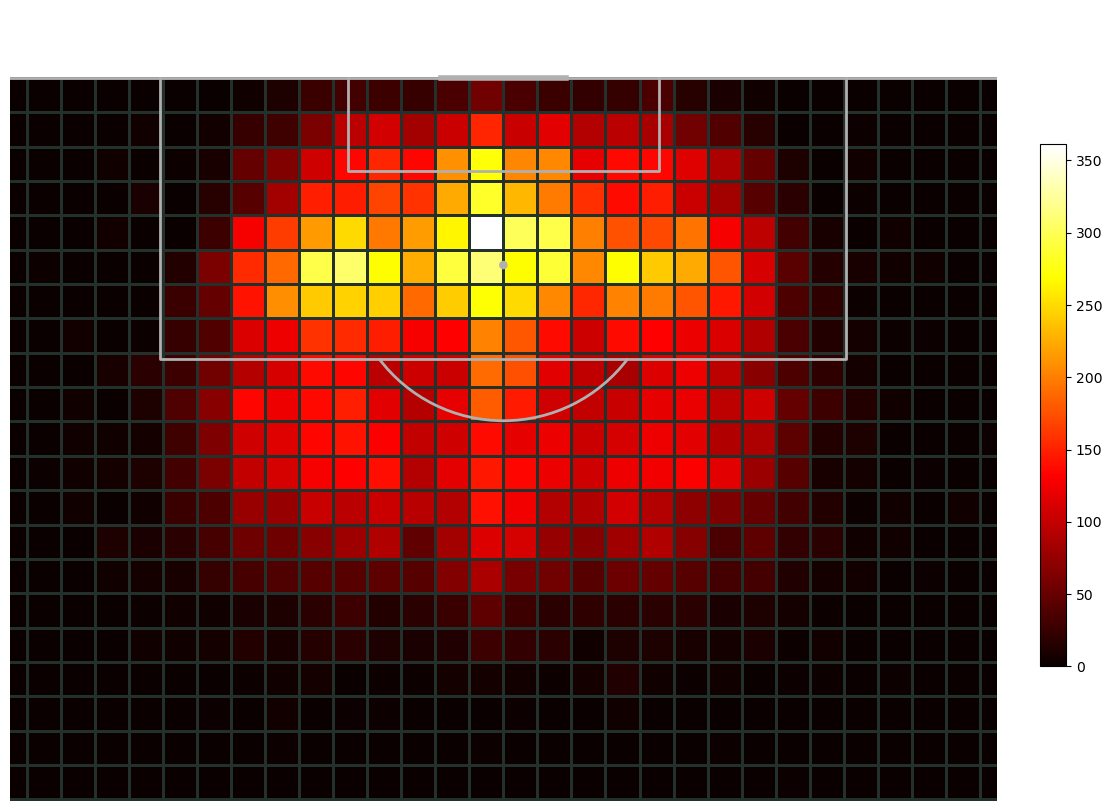

In [16]:
fig, ax = pitch.draw(figsize=(9*pitch.ax_aspect, 9))
bs = pitch.bin_statistic(df_subset.x, df_subset.y, statistic='count', bins=(52, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
fig.colorbar(pcm, fraction=0.045, pad=0.04, shrink=0.6)

Bin Statistics for each player, smoothed with gaussian filter

In [17]:
results = np.zeros((n_players, 34 * 52))
for i in range(n_players):
    df_player = df_subset[df_subset.player_id == player_ids[i]]
    bs = pitch.bin_statistic(df_player.x, df_player.y, statistic='count', bins=(52, 34))
    results[i] = gaussian_filter(bs['statistic'], 1.5).flatten()

Non-negative matrix factorisation

In [18]:
m = NMF(n_components=5, init='random', random_state=42)
matrix = m.fit_transform(results)
df_matrix = pd.DataFrame(matrix, index=player_ids)
H = m.components_

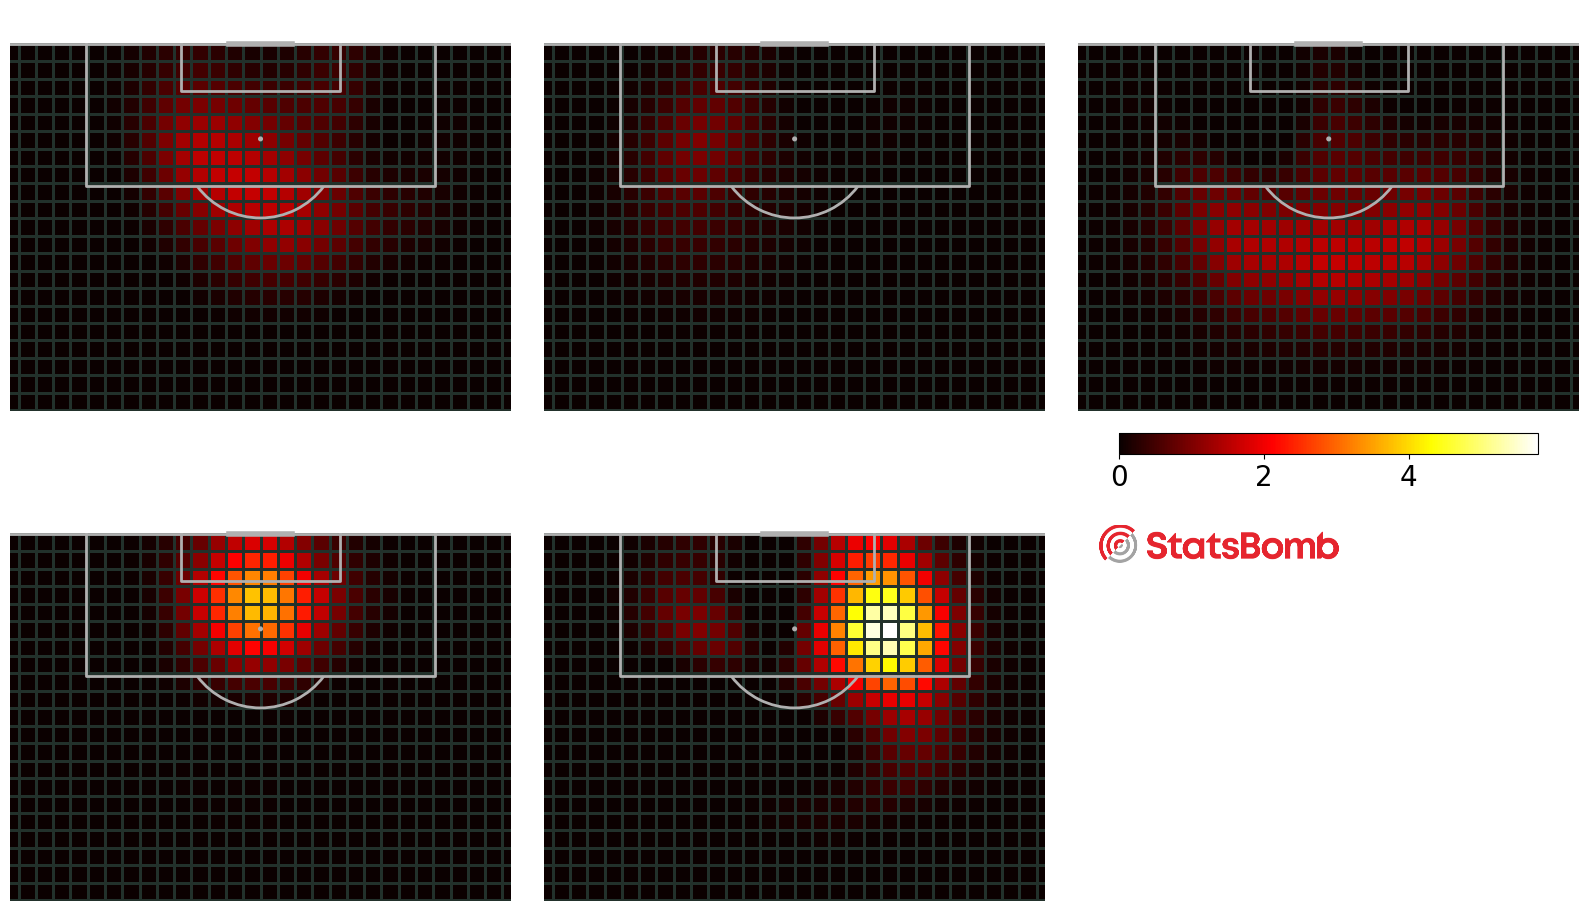

In [19]:
pitch = VerticalPitch(pitch_type='uefa', half=True,
                      pad_left=-5, pad_right=-5, pad_bottom=-10, line_zorder=2)
fig, axs = pitch.draw(figsize=(16, 9), ncols=3, nrows=2, tight_layout=False, constrained_layout=True)
axs[1, 2].remove()

bs['statistic'] = H[0].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 0], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[1].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 1], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[2].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 2], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[3].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[1, 0], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[4].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[1, 1], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

cbar = fig.colorbar(pcm, ax=[axs[0, 2]], location='bottom', shrink=0.8)
cbar.ax.tick_params(labelsize=20) 

ax_image = add_image(logo, fig, left=0.69, bottom=0.38, width=0.15, alpha=0.9, interpolation='hanning')

fig.savefig(os.path.join('..', 'figures', 'non-negative-matrix-factorization-shot-locations.png'),
            dpi=300, bbox_inches = 'tight', pad_inches = 0)

# Heatmap average xG values

In [20]:
standard = Standardizer(pitch_from='uefa', pitch_to='statsbomb')
new_x, new_y = standard.transform(df_all.x, df_all.y)
df_all['x_statsbomb'] = new_x
df_all['y_statsbomb'] = new_y

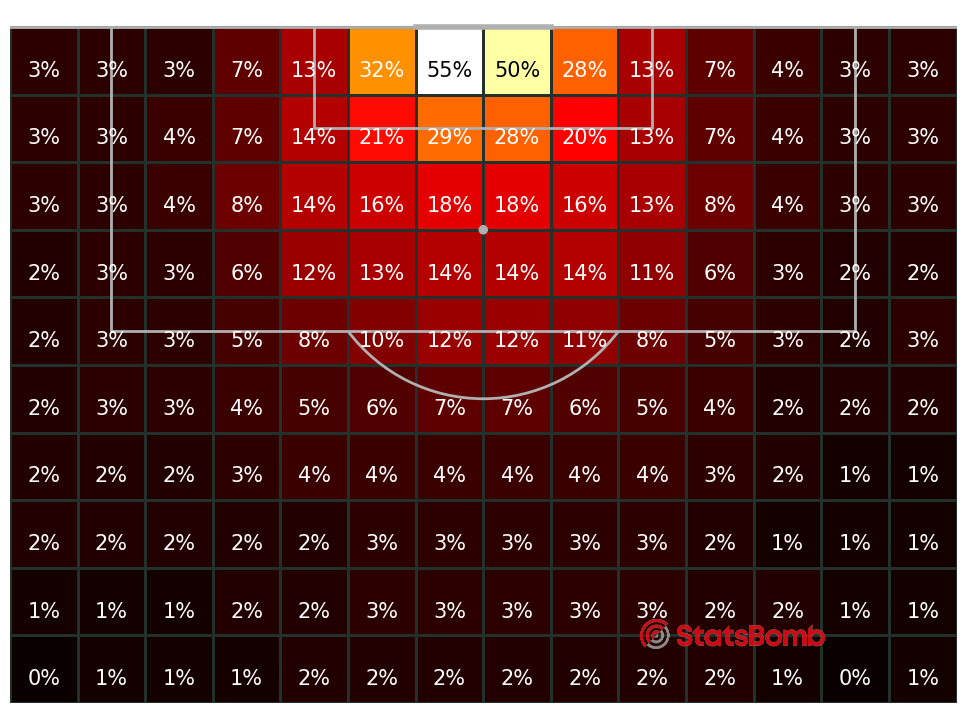

In [21]:
pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, half=True,
                      pad_left=-12, pad_right=-12, pad_bottom=-20, pad_top=1)
fig, ax = pitch.draw(figsize=(9*pitch.ax_aspect, 9), tight_layout=False)
bs = pitch.bin_statistic(df_all.x_statsbomb, df_all.y_statsbomb, df_all.xg, statistic='mean', bins=(30, 20))
bs['statistic'] = np.round(np.nan_to_num(bs['statistic']) * 100., 0).astype(np.int32)
vmax = bs['statistic'].max()
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
mask = bs['statistic'] > 40
bs['statistic'] = (pd.DataFrame(bs['statistic']).round(0).astype(np.int32).applymap(lambda x: '{:d}%'.format(x)).values)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='top', zorder=3)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='top', zorder=3)
ax_image = add_image(logo, fig, left=0.64, bottom=0.17, width=0.15, alpha=0.9, interpolation='hanning')

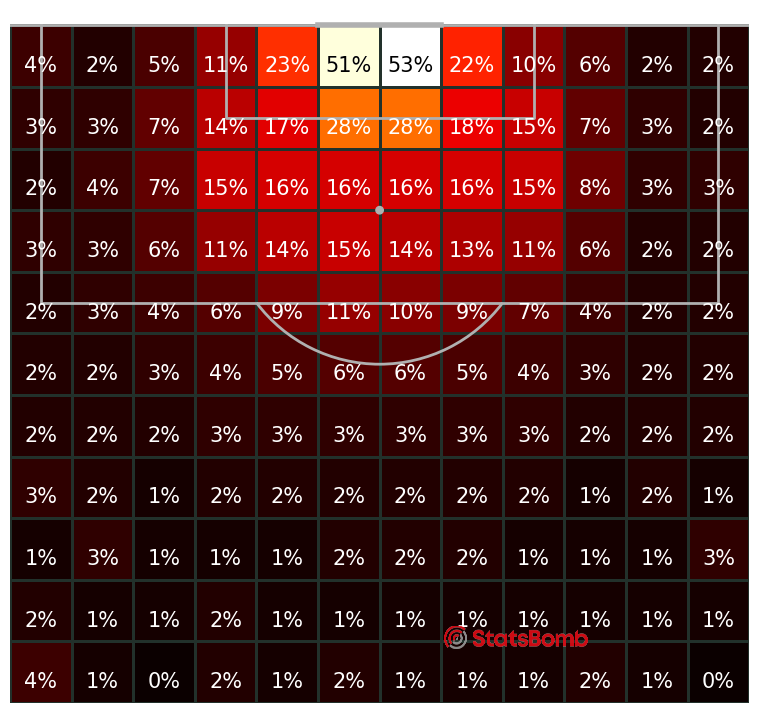

In [22]:
pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, half=True,
                      pad_left=-16, pad_right=-16, pad_bottom=-16, pad_top=1)
fig, ax = pitch.draw(figsize=(9*pitch.ax_aspect, 9), tight_layout=False)
mask_shot = (df_statsbomb_event.type_name == 'Shot') & (df_statsbomb_event.sub_type_name == 'Open Play')
bs = pitch.bin_statistic(df_statsbomb_event[mask_shot].x, df_statsbomb_event[mask_shot].y,
                         df_statsbomb_event[mask_shot].shot_statsbomb_xg,
                         statistic='mean', bins=(30, 20))
bs['statistic'] = np.round(np.nan_to_num(bs['statistic']) * 100., 0).astype(np.int32)
vmax = bs['statistic'].max()
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
mask = bs['statistic'] > 40
bs['statistic'] = (pd.DataFrame(bs['statistic']).round(0).astype(np.int32).applymap(lambda x: '{:d}%'.format(x)).values)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='top', zorder=3)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='top', zorder=3)
ax_image = add_image(logo, fig, left=0.58, bottom=0.17, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join('..', 'figures', '25_mean_xg_heatmap.png'), bbox_inches='tight', pad_inches=0)

# Permutation importance

In [23]:
perm_result = permutation_importance(model,
                                     df_X,
                                     df_lgbm.goal,
                                     n_repeats=10,
                                     random_state=42,
                                     n_jobs=-1)

In [24]:
features = df_X.columns
features = np.array([f.replace('_', ' ') for f in features])

df_perm_importance = pd.DataFrame({'Feature': features,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)

In [25]:
df_perm_importance

,Feature,importance,std_dev
0,x,0.014136,0.000384
1,y,0.010534,0.000346
2,n angle,0.001616,0.000262
3,goalkeeper x,0.001038,0.000138
4,body part name,0.001030,0.000177
5,shot type name,0.000745,0.000145
6,assist type,0.000535,0.000104
7,pass height name,0.000480,0.000109
8,pass end y,0.000471,0.000096
9,pass end x,0.000458,0.000144


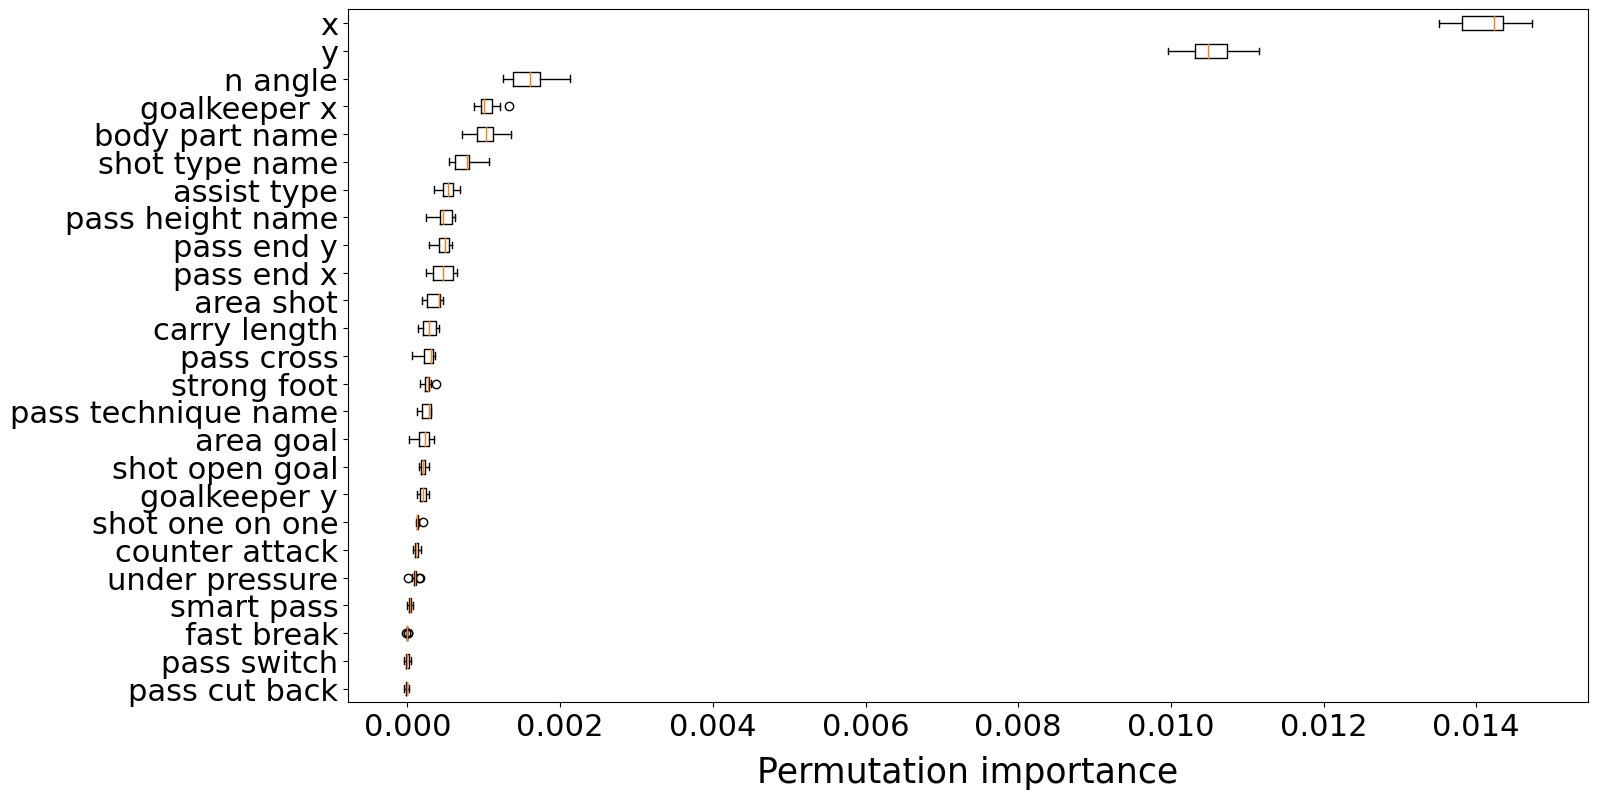

In [26]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
box_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=features[sorted_idx])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_xlabel('Permutation importance', labelpad=10, fontsize=25)
fig.savefig(os.path.join('..', 'figures', '26_model_perm_importance.png'), 
            bbox_inches='tight', pad_inches=0)

# Shap values

Filter only StatsBomb and add goalkeeper id

In [27]:
df_xg = df_xg.loc[df_xg['statsbomb_id'].notnull()].copy()
df_xg = df_xg.merge(df_all.loc[df_all.statsbomb_id.notnull(), ['statsbomb_id','player_id_goalkeeper']],
                    how='left', on='statsbomb_id', validate='1:1')
df_xg.drop('wyscout_id', axis=1, inplace=True)

Add nickname

In [28]:
df_statsbomb_lineup = df_statsbomb_lineup[['player_id', 'player_nickname', 'player_name']]
df_statsbomb_lineup.sort_values('player_nickname', inplace=True)
mask_nickname = df_statsbomb_lineup.player_nickname.isnull()
df_statsbomb_lineup.loc[mask_nickname, 'player_nickname'] = df_statsbomb_lineup.loc[mask_nickname, 'player_name']
df_statsbomb_lineup.drop_duplicates('player_id', keep='first', inplace=True)
df_statsbomb_lineup.drop('player_name', axis=1, inplace=True)
df_xg = df_xg.merge(df_statsbomb_lineup, left_on='player_id_goalkeeper', right_on='player_id', how='left')

Dataframe of nicknames

In [29]:
df_statsbomb_event['outcome_name'] = df_statsbomb_event.outcome_name.replace({'Off T': 'Off Target'})

Filter goalkeeper

In [30]:
#df_xg = df_xg[df_xg.player_nickname == 'Iker Casillas']

Add Shap values for goalkeeper position

In [31]:
df_xg['gk_contribution'] = df_xg[['goalkeeper x', 'goalkeeper y']].sum(axis=1).sort_values()

Sort values by contribution

In [32]:
df_xg.sort_values('gk_contribution', inplace=True)

In [33]:
idx = -2

In [34]:
shot_id = df_xg.iloc[idx].statsbomb_id
df_single_shot = df_statsbomb_event[df_statsbomb_event.id == shot_id].copy()
df_single_shot = df_single_shot.merge(df_statsbomb_lineup, how='left', on='player_id')
df_single_frame = df_statsbomb_freeze[df_statsbomb_freeze.id == shot_id].copy()
df_single_frame = df_single_frame.merge(df_statsbomb_lineup, how='left', on='player_id')

In [35]:
df_teammate = df_single_frame[df_single_frame.teammate].copy()
df_gk = df_single_frame[(~df_single_frame.teammate) & 
                        (df_single_frame.position_name == 'Goalkeeper')].copy()
df_other = df_single_frame[(~df_single_frame.teammate) & 
                           (df_single_frame.position_name != 'Goalkeeper')].copy()
outcome = df_single_shot.outcome_name.values[0]
team_name = df_single_shot.team_name.values[0]
player_name = df_single_shot.player_nickname.values[0]
if player_name is None:
    player_name = df_single_shot.player_name.values[0]
gk_name = df_gk.player_nickname.values[0]
if gk_name is None:
    gk_name = df_gk.player_name.values[0]
match_id = df_single_shot.match_id.values[0]

In [36]:
home_team = df_statsbomb_match[df_statsbomb_match.match_id == match_id].home_team_name.values[0]
away_team = df_statsbomb_match[df_statsbomb_match.match_id == match_id].away_team_name.values[0]
date = df_statsbomb_match[df_statsbomb_match.match_id == match_id].match_date.values[0].astype('str')[:10]
if home_team == team_name:
    other_team = away_team
else:
    other_team = home_team

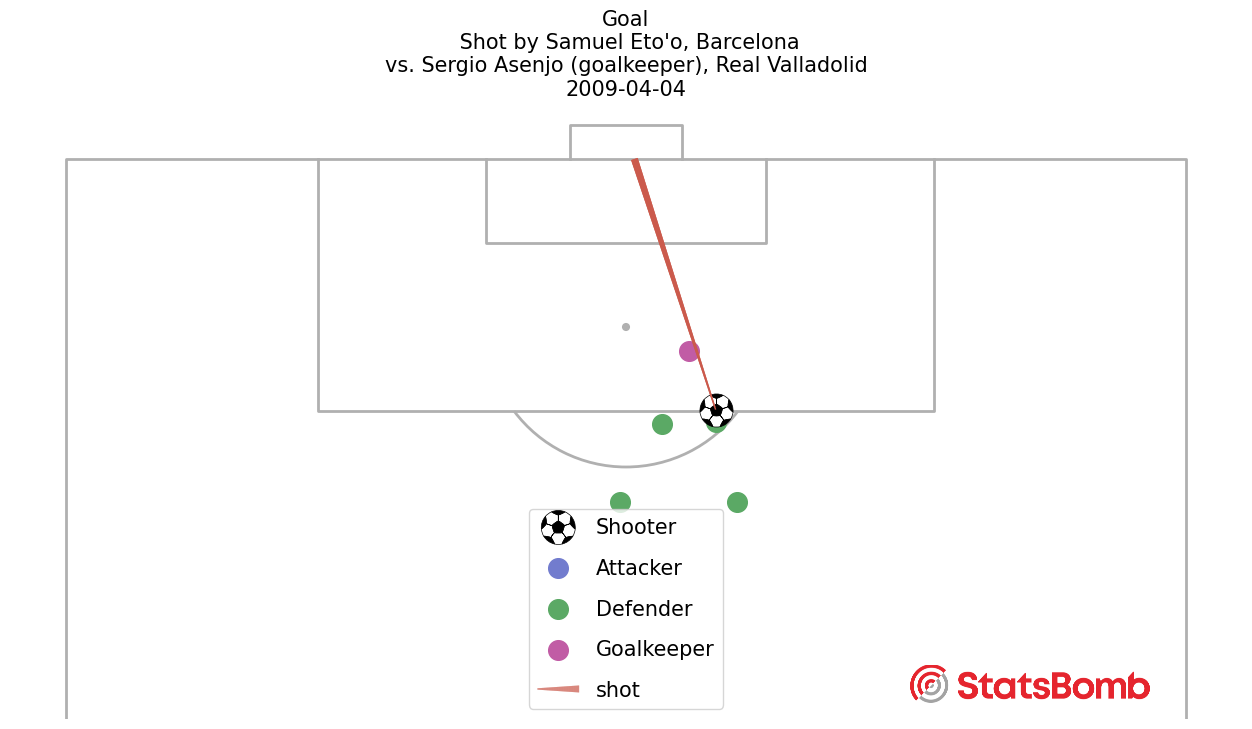

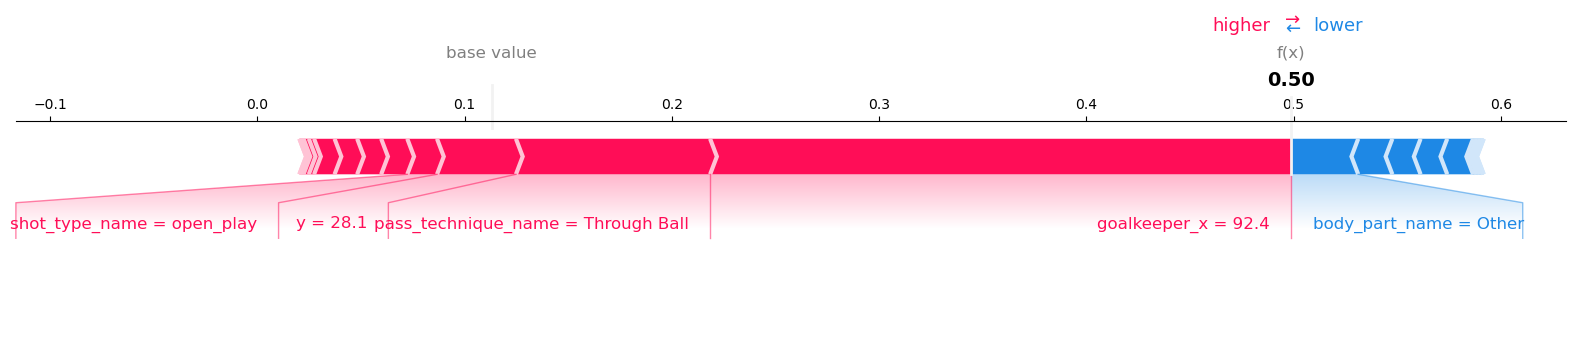

In [37]:
fig, ax = plt.subplots(figsize=(16, 8), tight_layout=False)
pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-20)
pitch.draw(ax=ax)
ax_image = add_image(logo, fig, left=0.69, bottom=0.13, width=0.15, alpha=0.9, interpolation='hanning')
sc1 = pitch.scatter(df_single_shot.x, df_single_shot.y, marker='football', s=600, ax=ax, label='Shooter', zorder=1.2)
sc2 = pitch.scatter(df_teammate.x, df_teammate.y, s=200, c='#727cce', label='Attacker', ax=ax)
sc3 = pitch.scatter(df_other.x, df_other.y, s=200, c='#5ba965', label='Defender', ax=ax)
sc4 = pitch.scatter(df_gk.x, df_gk.y, s=200, ax=ax, c='#c15ca5', label='Goalkeeper')
line = pitch.lines(df_single_shot.x, df_single_shot.y, 
                   df_single_shot.end_x, df_single_shot.end_y,
                   comet=True, label='shot', color='#cb5a4c', ax=ax)
legend = ax.legend(labelspacing=1, fontsize=15)
title = (f'{outcome}\n Shot by {player_name}, {team_name}\n'
         f'vs. {gk_name} (goalkeeper), {other_team}\n'
         f'{date}')
ax.set_title(title, fontsize=15)
features = df_all.loc[df_all.statsbomb_id == shot_id, df_X.columns]
float_cols = ['x', 'y', 'pass_end_x', 'pass_end_y', 'carry_length', 'area_shot',
              'area_goal', 'n_angle', 'goalkeeper_x', 'goalkeeper_y']
features[float_cols] = features[float_cols].round(1)
shap.force_plot(df_xg.loc[df_xg.statsbomb_id == shot_id, df_xg.columns[-5]].values[0], 
                df_xg.loc[df_xg.statsbomb_id == shot_id, df_xg.columns[3:-5]].values,
                features=features.astype(str),
                feature_names=df_X.columns, matplotlib=True)

In [38]:
df_all.loc[df_all.statsbomb_id == shot_id, ['shot_statsbomb_xg', 'xg', 'xg_difference']]

,shot_statsbomb_xg,xg,xg_difference
25238,0.21208,0.498922,-0.286842


In [39]:
df_xg[df_xg.statsbomb_id == shot_id].gk_contribution

25238    0.290343
Name: gk_contribution, dtype: float64

Average contributions

In [40]:
df_xg = df_xg.merge(df_statsbomb_match[['match_id', 'home_team_gender']], on='match_id', how='left')
df_xg.loc[df_xg.home_team_gender.isnull(), 'home_tean_gender'] = 'female'

In [41]:
df_xg['good_position'] = df_xg['gk_contribution'] <= -0.01
df_xg['poor_position'] = df_xg['gk_contribution'] >= 0.05

In [42]:
gk_200_shots = df_xg.player_id.value_counts()[df_xg.player_id.value_counts() >= 200].index
df_xg = df_xg[df_xg.player_id.isin(gk_200_shots)].copy()

In [43]:
gk_contribution = df_xg.groupby(['player_id', 'player_nickname', 'home_team_gender'])['good_position', 'poor_position'].mean()
goal_counts = df_xg.groupby(['player_id', 'player_nickname', 'home_team_gender']).player_id.count()
df_contribution = pd.DataFrame(gk_contribution).merge(pd.DataFrame(goal_counts), left_index=True, right_index=True)
df_contribution.rename({'player_id': 'shot_count'}, axis=1, inplace=True)
df_contribution.sort_values('good_position', ascending=False, inplace=True)
df_contribution['good_position'] = (df_contribution['good_position'] * 100).round(0)
df_contribution['poor_position'] = (df_contribution['poor_position'] * 100).round(0)
df_contribution.reset_index(drop=False, inplace=True)

In [44]:
df_contribution

,player_id,player_nickname,home_team_gender,good_position,poor_position,shot_count
0,6576,Gorka Iraizoz,male,17.0,12.0,256
1,6768,Diego López,male,17.0,12.0,217
2,16376,Sophie Baggaley,female,14.0,5.0,996
3,5597,Keylor Navas,male,13.0,12.0,214
4,15576,Kirstie Levell,female,13.0,2.0,262
5,4691,Claudio Bravo,male,13.0,7.0,696
6,13857,Tinja-Riikka Tellervo Korpela,female,12.0,6.0,265
7,6755,Sergio Asenjo,male,12.0,17.0,257
8,26005,José Manuel Pinto,male,12.0,9.0,223
9,25144,Diego Alves,male,11.0,9.0,279
